In [1]:
import os
import random
import zipfile

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# Dataset download

In [2]:
ROOT_PATH = os.path.join("..", "data", "raw")
DATASET_PATH = os.path.join(ROOT_PATH, "Garbage_Dataset_Classification")
ZIP_FILE = os.path.join(ROOT_PATH, "garbage-dataset.zip")

# Direct Kaggle download link
KAGGLE_URL = "https://www.kaggle.com/api/v1/datasets/download/zlatan599/garbage-dataset-classification"

In [3]:
def download_with_curl():
    """
    Download Kaggle dataset using curl + API credentials.
    Requires: ~/.kaggle/kaggle.json with username + key
    """
    print("Downloading dataset with curl...")

    # Make sure ~/.kaggle exists and is secure
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    os.chmod(os.path.expanduser("~/.kaggle"), 0o700)

    # Run curl command (requires kaggle.json for auth)
    cmd = f"curl -L -o {ZIP_FILE} -u `jq -r .username ~/.kaggle/kaggle.json`:`jq -r .key ~/.kaggle/kaggle.json` {KAGGLE_URL}"
    os.system(cmd)

    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
        zip_ref.extractall(ROOT_PATH)
    
    os.remove(ZIP_FILE)

In [4]:
if not os.path.exists(DATASET_PATH):
    download_with_curl()
else:
    print(f"{DATASET_PATH} already exists, nothing to do.")

../data/raw/Garbage_Dataset_Classification already exists, nothing to do.


# Dataset exploration

## Dataset folder structure

In [5]:
for root, dirs, files in os.walk(DATASET_PATH):
    print(root, len(files))

../data/raw/Garbage_Dataset_Classification 1
../data/raw/Garbage_Dataset_Classification/images 0
../data/raw/Garbage_Dataset_Classification/images/metal 2084
../data/raw/Garbage_Dataset_Classification/images/paper 2315
../data/raw/Garbage_Dataset_Classification/images/plastic 2288
../data/raw/Garbage_Dataset_Classification/images/glass 2500
../data/raw/Garbage_Dataset_Classification/images/trash 2500
../data/raw/Garbage_Dataset_Classification/images/cardboard 2214


## Metadata

In [6]:
# Load metadata
metadata_path = os.path.join(DATASET_PATH, "metadata.csv")
df = pd.read_csv(metadata_path)

# Quick look at the data
print(df.head())
print()
print(df['label'].value_counts())

              filename      label
0  cardboard_02038.jpg  cardboard
1  cardboard_02320.jpg  cardboard
2  cardboard_01728.jpg  cardboard
3  cardboard_00093.jpg  cardboard
4  cardboard_00094.jpg  cardboard

label
glass        2500
trash        2500
paper        2315
plastic      2288
cardboard    2214
metal        2084
Name: count, dtype: int64


## Sample visualization

In [7]:
def plot_random_examples_per_class(df, dataset_path, filename=None):
    """
    Plots a random image from each class with colored borders using seaborn palette.

    df: pandas DataFrame with a 'label' column
    dataset_path: path to folder containing dataset images
    filename (optional): filename of the PDF file where shown image will be dumped
    """
    classes = df['label'].unique()
    n_classes = len(classes)
    
    # Seaborn palette for consistent class colors
    palette = sns.color_palette("tab10", n_classes)
    class_colors = {cls: palette[i] for i, cls in enumerate(classes)}
    
    # Determine grid size
    cols = 3
    rows = (n_classes + cols - 1) // cols
    plt.figure(figsize=(cols*4, rows*4))
    
    for i, cls in enumerate(classes):
        img_filename = df[df['label']==cls].sample(1).iloc[0]['filename']
        img_path = os.path.join(dataset_path, "images", cls, img_filename)
        img = Image.open(img_path)
        
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(cls, fontsize=14, color=class_colors[cls])
        ax.axis("off")
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(class_colors[cls])
            spine.set_linewidth(4)
    
    plt.tight_layout()
    if filename != None:
        plt.savefig(filename, dpi=150)
    plt.show()

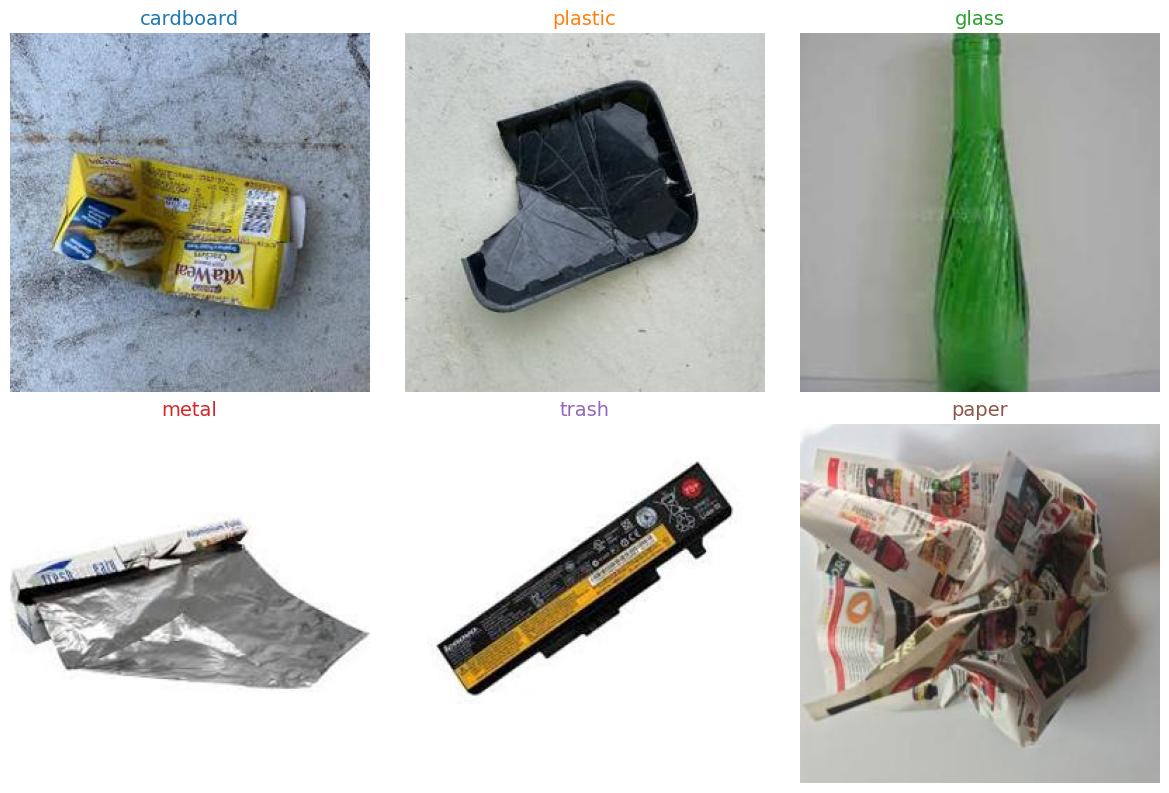

In [21]:
plot_random_examples_per_class(
    df,
    DATASET_PATH,
    os.path.join('..', 'reports', 'figures', 'EDA', 'random_examples_per_class.pdf')
)

## Class distribution

In [8]:
def plot_class_distribution(df, filename=None):
    """
    Plots the class distribution using seaborn countplot.
    
    df: pandas DataFrame with a 'label' column
    dataset_path: path to folder containing dataset images
    filename (optional): filename of the PDF file where shown image will be dumped
    """
    plt.figure(figsize=(8, 5))
    sns.countplot(
        data=df,
        x="label",
        hue="label",  # assign hue
        order=df['label'].value_counts().index,
        palette="tab10",
        legend=False  # disable redundant legend
    )
    plt.title("Class Distribution", fontsize=16)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if filename != None:
        plt.savefig(filename, dpi=150)
    plt.show()

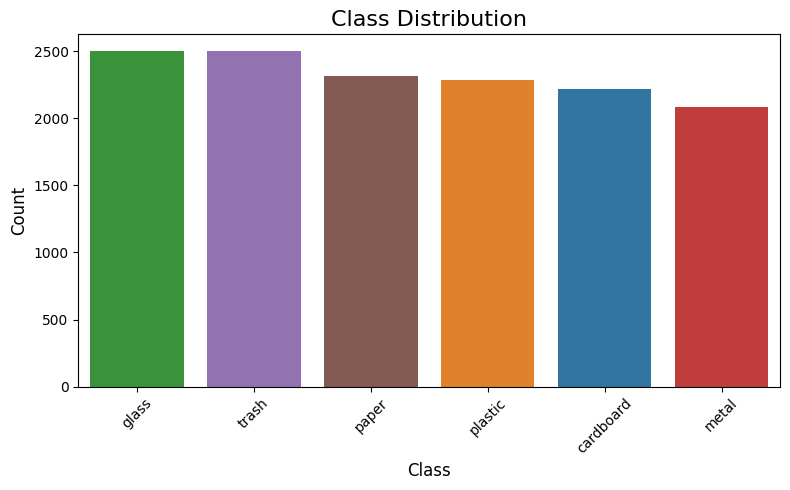

In [26]:
plot_class_distribution(
    df,
    os.path.join('..', 'reports', 'figures', 'EDA', 'class_distribution.pdf')
)

Dataset seems to be quite balanced.

## Image Sizes

In [9]:
def plot_image_size_scatter(df, dataset_path, filename=None):
    """
    Plots a scatter plot of image dimensions (Width vs Height),
    colored by label and using different markers for each class.
    
    df: pandas DataFrame with 'filename' and 'label' columns
    dataset_path: path to the root dataset folder
    """
    # Extract image sizes
    widths, heights, labels = [], [], []
    for _, row in df.iterrows():
        img_path = os.path.join(dataset_path, "images", row['label'], row['filename'])
        try:
            with Image.open(img_path) as img:
                w, h = img.size
        except:
            continue
        widths.append(w)
        heights.append(h)
        labels.append(row['label'])
    
    # Build a new DataFrame with sizes
    size_df = pd.DataFrame({
        "Width": widths,
        "Height": heights,
        "Label": labels
    })
    
    # Define markers (cycled if there are more classes than markers)
    markers = ["o", "s", "X", "D", "^", "v"]
    
    # Create scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=size_df,
        x="Width",
        y="Height",
        hue="Label",
        style="Label",  # different markers
        palette="tab10",
        markers=markers
    )
    
    plt.title("Image Dimensions per Class", fontsize=16)
    plt.xlabel("Width", fontsize=12)
    plt.ylabel("Height", fontsize=12)
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    if filename != None:
        plt.savefig(filename, dpi=150)
    plt.show()

    print(f"Image sizes:")
    print(f"Min width: {np.min(widths)}")
    print(f"Max width: {np.max(widths)}")
    print(f"Min height: {np.min(heights)}")
    print(f"Max height: {np.max(heights)}")

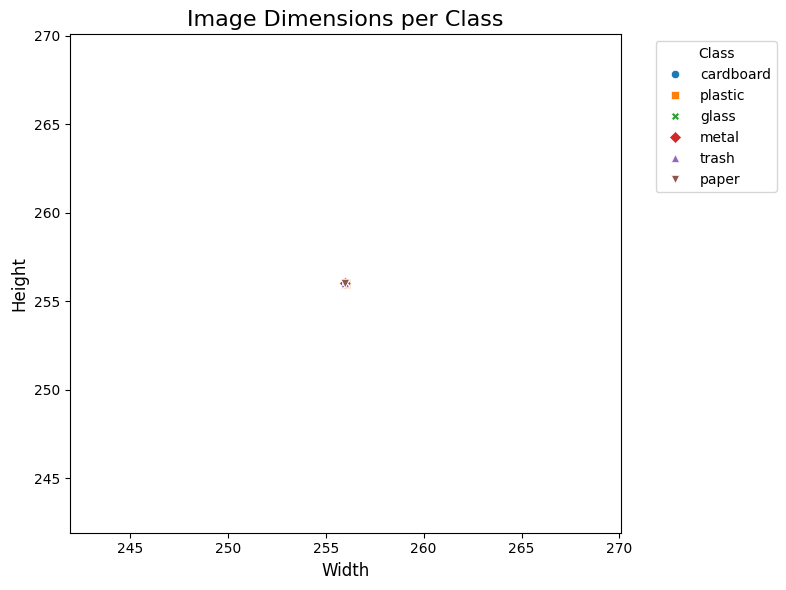

Image sizes:
Min width: 256
Max width: 256
Min height: 256
Max height: 256


In [34]:
plot_image_size_scatter(
    df,
    DATASET_PATH
)

Good. All images are of the same size.

## Prototypes and correlations

In [10]:
def plot_mean_images_per_class(df, dataset_path, filename=None):
    """
    Computes and plots the mean image for each class.
    
    df: pandas DataFrame with 'filename' and 'label' columns
    dataset_path: path to the root dataset folder
    """
    classes = df['label'].unique()
    mean_images = {}
    
    for cls in classes:
        imgs = []
        subset = df[df['label'] == cls]
        
        for _, row in subset.iterrows():
            img_path = os.path.join(dataset_path, "images", row['label'], row['filename'])
            try:
                img = Image.open(img_path).convert("RGB")
                imgs.append(np.array(img, dtype=np.float32))
            except:
                continue
        
        if imgs:
            mean_img = np.mean(imgs, axis=0) / 255.0  # normalize to [0,1]
            mean_images[cls] = mean_img
    
    # Plot results
    cols = 3
    rows = (len(classes) + cols - 1) // cols
    plt.figure(figsize=(cols*4, rows*4))
    
    for i, (cls, mean_img) in enumerate(mean_images.items()):
        plt.subplot(rows, cols, i+1)
        plt.imshow(mean_img)
        plt.title(f"Mean {cls}", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    if filename != None:
        plt.savefig(filename, dpi=150)
    plt.show()

In [12]:
def plot_median_images_per_class(df, dataset_path, filename=None):
    """
    Computes and plots the median image for each class.
    
    df: pandas DataFrame with 'filename' and 'label' columns
    dataset_path: path to the root dataset folder
    """
    classes = df['label'].unique()
    median_images = {}
    
    for cls in classes:
        imgs = []
        subset = df[df['label'] == cls]
        
        for _, row in subset.iterrows():
            img_path = os.path.join(dataset_path, "images", row['label'], row['filename'])
            try:
                img = Image.open(img_path).convert("RGB")
                imgs.append(np.array(img, dtype=np.float32))
            except:
                continue
        
        if imgs:
            # Stack into one array (N, H, W, C)
            imgs_stack = np.stack(imgs, axis=0)
            median_img = np.median(imgs_stack, axis=0) / 255.0  # normalize to [0,1]
            median_images[cls] = median_img
    
    # Plot results
    cols = 3
    rows = (len(classes) + cols - 1) // cols
    plt.figure(figsize=(cols*4, rows*4))
    
    for i, (cls, median_img) in enumerate(median_images.items()):
        plt.subplot(rows, cols, i+1)
        plt.imshow(median_img)
        plt.title(f"Median {cls}", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    if filename != None:
        plt.savefig(filename, dpi=150)
    plt.show()

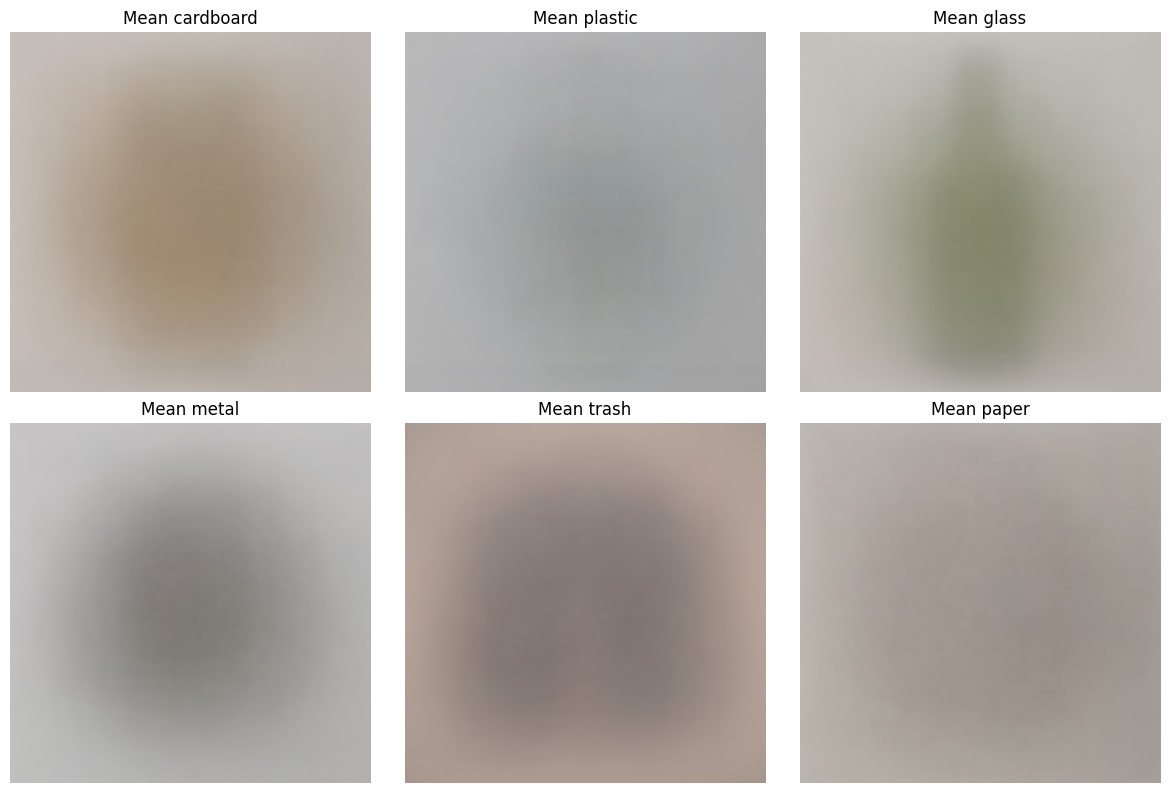

In [11]:
plot_mean_images_per_class(
    df,
    DATASET_PATH,
    os.path.join('..', 'reports', 'figures', 'EDA', 'class_prototypes_mean.pdf')
)

In [ ]:
plot_median_images_per_class(
    df,
    DATASET_PATH,
    os.path.join('..', 'reports', 'figures', 'EDA', 'class_prototypes_median.pdf')
)